In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debashish0sarker","key":"889ec46e790212e1771d258ca88d6db4"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d debashish0sarker/captcha-shortened

Dataset URL: https://www.kaggle.com/datasets/debashish0sarker/captcha-shortened
License(s): unknown
 98% 3.29G/3.35G [00:52<00:00, 147MB/s]
100% 3.35G/3.35G [00:52<00:00, 68.2MB/s]


In [5]:
!unzip captcha-shortened.zip -d captcha_shortened

Streaming output truncated to the last 5000 lines.
  inflating: captcha_shortened/SPHINX_shortened/ZOUA_378480.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUB_423764.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_118519.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_601525.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUF_386752.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUG_855976.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_232716.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_709128.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_524944.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_814891.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_195100.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_317513.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUP_563916.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUQ_404157.png  
  inflating: captcha_shor

In [6]:
!pip install -q torchsummary

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import string


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# CAPTCHA setup
ALPHABET = string.ascii_uppercase
NUM_CLASSES = len(ALPHABET) + 1   # +1 for CTC blank
IMG_HEIGHT, IMG_WIDTH = 40, 150
BATCH_SIZE = 64
EPOCHS = 10


Using device: cuda


In [10]:
print(NUM_CLASSES)

27


In [11]:
class CAPTCHADataset(Dataset):
    def __init__(self, data_dir, transform=None, alphabet=ALPHABET, max_len=4):
        self.data_dir = data_dir
        self.transform = transform
        self.alphabet = alphabet
        self.max_len = max_len

        self.char_to_idx = {c: i+1 for i,c in enumerate(alphabet)}  # 1..26
        self.idx_to_char = {i+1: c for i,c in enumerate(alphabet)}
        self.blank_idx = 0  # reserved for CTC blank

        self.image_paths, self.labels = [], []
        for fname in sorted(os.listdir(data_dir)):
            if fname.lower().endswith((".png",".jpg",".jpeg")):
                label = fname.split("_")[0][:max_len].upper()
                if all(c in alphabet for c in label):
                    self.image_paths.append(os.path.join(data_dir, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        label_idx = [self.char_to_idx[c] for c in label]

        return img, torch.tensor(label_idx, dtype=torch.long), len(label_idx)


In [12]:
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def get_loaders(data_dir, batch_size=64, val_split=0.2):
    dataset = CAPTCHADataset(data_dir, transform=transform)
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return dataset, train_loader, val_loader

DATA_DIR = "/content/captcha_shortened/SPHINX_shortened"  # change if needed
dataset, train_loader, val_loader = get_loaders(DATA_DIR, BATCH_SIZE)


In [13]:
class CRNN(nn.Module):
    def __init__(self, img_h=40, num_classes=NUM_CLASSES, hidden_size=256):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2,2),   # 20x75
            nn.Conv2d(64,128,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),     # 10x37
            nn.Conv2d(128,256,3,1,1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256,256,3,1,1), nn.ReLU(), nn.MaxPool2d((2,2),(2,1),(0,1)), # 5x37
            nn.Conv2d(256,512,3,1,1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512,512,3,1,1), nn.ReLU(), nn.MaxPool2d((2,2),(2,1),(0,1)), # 2x37
            nn.Conv2d(512,512,2,1,0), nn.ReLU()  # 1x36
        )

        self.lstm = nn.LSTM(512, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        conv = self.cnn(x)     # (B, C, H, W)
        b,c,h,w = conv.size()
        conv = conv.squeeze(2).permute(0,2,1)  # (B, W, C)
        rnn_out,_ = self.lstm(conv)
        out = self.fc(rnn_out)  # (B, W, num_classes)
        return out.permute(1,0,2) # (T,B,C) for CTC


In [15]:
# Create the model
model = CRNN(num_classes=NUM_CLASSES, hidden_size=256).to(device)

print("Model created:")
summary(model, (1, 1, 40, 150))  # include channel dimension: (batch, channels, H, W)


Model created:


NameError: name 'summary' is not defined

In [14]:
!pip install torchinfo


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_mb = (total_params * 4) / (1024*1024)  # float32 = 4 bytes

print(f"📊 Total parameters: {total_params:,}")
print(f"✅ Trainable parameters: {trainable_params:,}")
print(f"💾 Model size (float32): {model_size_mb:.2f} MB")


📊 Total parameters: 7,141,147
✅ Trainable parameters: 7,141,147
💾 Model size (float32): 27.24 MB


In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [19]:
import os

CKPT_DIR   = "/kaggle/working/checkpoints"
LATEST_CKPT = os.path.join(CKPT_DIR, "latest_checkpoint.pth")
BEST_CKPT   = os.path.join(CKPT_DIR, "best_model.pth")

os.makedirs(CKPT_DIR, exist_ok=True)

def save_checkpoint(state, path):
    torch.save(state, path)

def load_latest_if_available(model, optimizer, scheduler, history):
    start_epoch = 0
    best_val_seq_acc = 0.0
    best_epoch = 0

    if os.path.exists(LATEST_CKPT):
        print("🔄 Loading latest checkpoint...")
        ckpt = torch.load(LATEST_CKPT, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

        # ✅ Only load scheduler if it's provided
        if scheduler is not None and "scheduler_state_dict" in ckpt:
            scheduler.load_state_dict(ckpt["scheduler_state_dict"])

        start_epoch = ckpt["epoch"] + 1
        history.update(ckpt["history"])
        best_val_seq_acc = ckpt.get("best_val_seq_acc", 0.0)
        best_epoch = ckpt.get("best_epoch", 0)
        print(f"✅ Resumed from epoch {start_epoch}")
    return start_epoch, best_val_seq_acc, best_epoch

In [20]:
def train_crnn_with_ckpt(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    history = {
        "train_loss": [], "val_loss": [],
        "train_char_acc": [], "val_char_acc": [],
        "train_seq_acc": [],  "val_seq_acc": []
    }
    start_epoch, best_val_seq_acc, best_epoch = load_latest_if_available(model, optimizer, scheduler, history)

    for epoch in range(start_epoch, epochs):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        running_char, running_seq, batches = 0, 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for imgs, labels, lengths in pbar:
            imgs = imgs.to(device)
            flat_labels = torch.cat([l for l in labels]).to(device)
            label_lengths = torch.tensor(lengths, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(imgs)  # (T,B,C)
            T,B,C = outputs.size()
            input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long)

            loss = criterion(outputs, flat_labels, input_lengths, label_lengths)
            loss.backward(); optimizer.step()

            running_loss += loss.item()

            # Accuracy
            c_acc, seq_acc = calculate_accuracy(outputs, labels, lengths)
            running_char += c_acc; running_seq += seq_acc; batches += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        avg_train_char_acc = running_char / batches
        avg_train_seq_acc = running_seq / batches

        # ---- Validate ----
        model.eval()
        val_loss, val_char, val_seq, v_batches = 0,0,0,0
        with torch.no_grad():
            for imgs, labels, lengths in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                imgs = imgs.to(device)
                flat_labels = torch.cat([l for l in labels]).to(device)
                label_lengths = torch.tensor(lengths, dtype=torch.long)

                outputs = model(imgs)
                T,B,C = outputs.size()
                input_lengths = torch.full(size=(B,), fill_value=T, dtype=torch.long)

                loss = criterion(outputs, flat_labels, input_lengths, label_lengths)
                val_loss += loss.item()

                c_acc, seq_acc = calculate_accuracy(outputs, labels, lengths)
                val_char += c_acc; val_seq += seq_acc; v_batches += 1

        avg_val_loss = val_loss / len(val_loader)
        avg_val_char_acc = val_char / v_batches
        avg_val_seq_acc = val_seq / v_batches

        if scheduler is not None:
          scheduler.step(avg_val_loss)

        # ---- Save history ----
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_char_acc"].append(avg_train_char_acc)
        history["val_char_acc"].append(avg_val_char_acc)
        history["train_seq_acc"].append(avg_train_seq_acc)
        history["val_seq_acc"].append(avg_val_seq_acc)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Char Acc: {avg_train_char_acc*100:.2f}% | Train Seq Acc: {avg_train_seq_acc*100:.2f}%")
        print(f"Val   Loss: {avg_val_loss:.4f} | Val Char Acc: {avg_val_char_acc*100:.2f}% | Val Seq Acc: {avg_val_seq_acc*100:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # ---- Save latest ----
        latest_state = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "history": history,
            "best_val_seq_acc": best_val_seq_acc,
            "best_epoch": best_epoch,
        }
# Only add scheduler if exists
        if scheduler is not None:
            latest_state["scheduler_state_dict"] = scheduler.state_dict()

        save_checkpoint(latest_state, LATEST_CKPT)

        # ---- Save epoch checkpoint ----
        epoch_ckpt_path = os.path.join(CKPT_DIR, f"epoch_{epoch+1:03d}.pth")
        save_checkpoint(latest_state, epoch_ckpt_path)
        print(f"📁 Checkpoint saved: {epoch_ckpt_path}")

        # ---- Save best (by full-sequence acc) ----
        if avg_val_seq_acc > best_val_seq_acc:
            best_val_seq_acc = avg_val_seq_acc
            best_epoch = epoch + 1
            best_state = {
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "val_char_acc": avg_val_char_acc,
                "val_seq_acc": avg_val_seq_acc,
                "config": {"num_classes": NUM_CLASSES}
            }
            save_checkpoint(best_state, BEST_CKPT)
            print(f"🏆 New BEST model saved (Seq Acc: {avg_val_seq_acc*100:.2f}% at epoch {best_epoch})")

        print("-"*60)

    # ---- Save final model ----
    final_path = os.path.join(CKPT_DIR, "final_model.pth")
    torch.save({
        "epoch": epochs,
        "model_state_dict": model.state_dict(),
        "final_history": history
    }, final_path)
    print(f"🎉 Training completed.")
    print(f"🏆 Best full-sequence val accuracy: {best_val_seq_acc*100:.2f}% at epoch {best_epoch}")

    return history


In [21]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Run training without scheduler
history = train_crnn_with_ckpt(
    model, train_loader, val_loader,
    criterion, optimizer, None, EPOCHS
)


🔄 Loading latest checkpoint...
✅ Resumed from epoch 10
🎉 Training completed.
🏆 Best full-sequence val accuracy: 98.35% at epoch 8


In [22]:
def ctc_decode(output, idx_to_char):
    pred = output.argmax(2).permute(1,0) # (B,T)
    results = []
    for seq in pred:
        s=[]; prev=-1
        for idx in seq:
            if idx!=prev and idx!=0:
                s.append(idx_to_char.get(idx.item(),""))
            prev=idx
        results.append("".join(s))
    return results


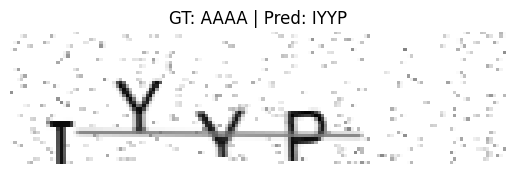

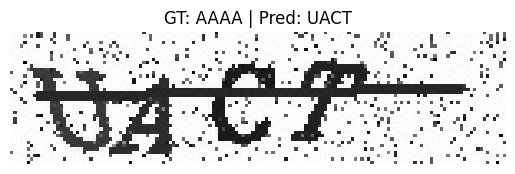

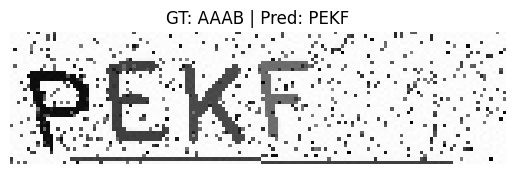

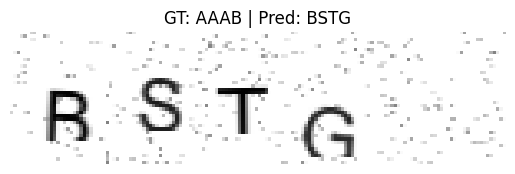

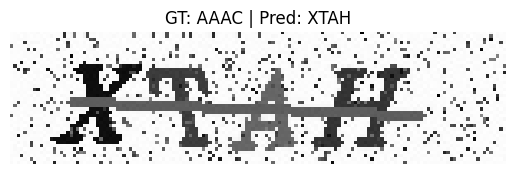

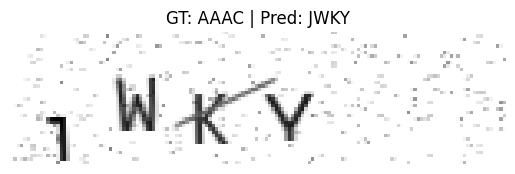

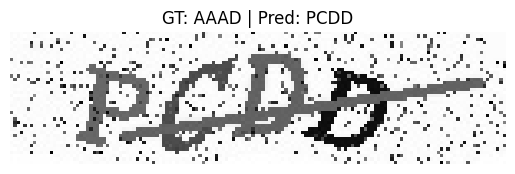

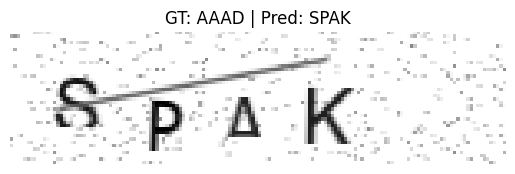

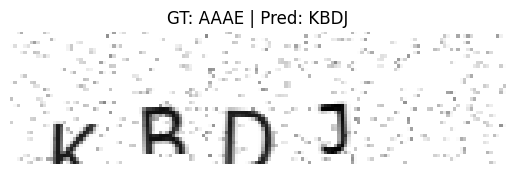

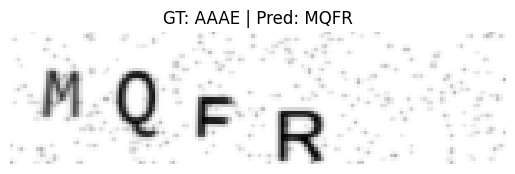

In [23]:
model.eval()
imgs, labels, lengths = next(iter(val_loader))
imgs = imgs.to(device)
outputs = model(imgs)
decoded = ctc_decode(outputs.cpu(), dataset.idx_to_char)

for i in range(10):
    plt.imshow(imgs[i].cpu().squeeze(), cmap="gray")
    plt.title(f"GT: {dataset.labels[i]} | Pred: {decoded[i]}")
    plt.axis("off")
    plt.show()


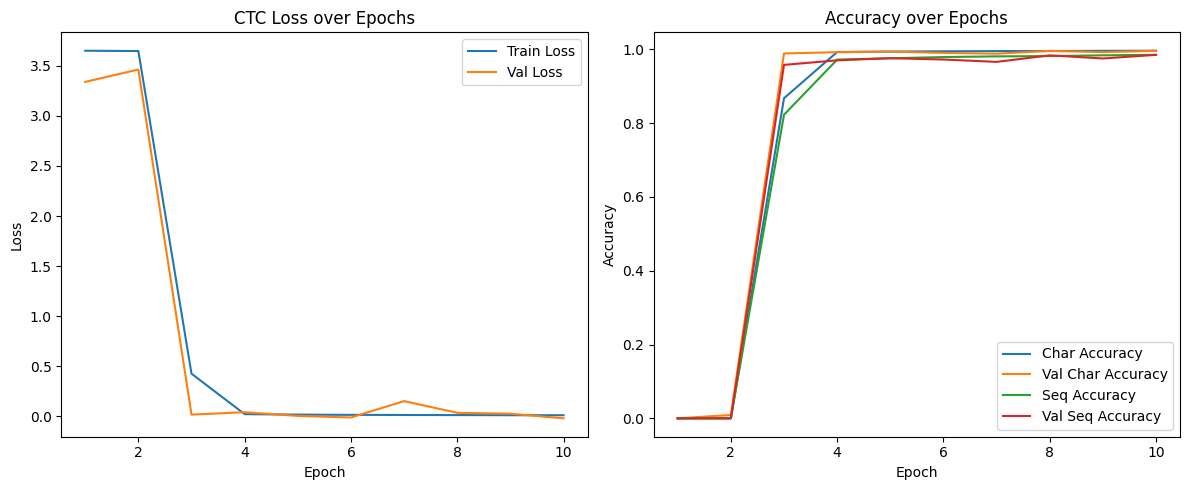

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss'])+1)

    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label="Train Loss")
    plt.plot(epochs, history['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CTC Loss over Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_char_acc'], label="Char Accuracy")
    plt.plot(epochs, history['val_char_acc'], label="Val Char Accuracy")
    plt.plot(epochs, history['train_seq_acc'], label="Seq Accuracy")
    plt.plot(epochs, history['val_seq_acc'], label="Val Seq Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [25]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ---- Update your alphabet mapping ----
# Ensure blank=0, then A=1..Z=26
ALPHABET = "-" + string.ascii_uppercase   # "-" = blank for CTC
char_to_idx = {c: i for i, c in enumerate(ALPHABET)}
idx_to_char = {i: c for c, i in char_to_idx.items()}

# ---- Greedy CTC Decoder ----
def ctc_greedy_decode(preds, idx_to_char):
    """
    preds: numpy array of shape (T,) or (T,B) with indices
    Returns: decoded string (collapses repeats, skips blanks)
    """
    out = []
    prev = -1
    for x in preds:
        if x != prev and x != 0:   # skip blanks (0) and consecutive repeats
            out.append(idx_to_char[x])
        prev = x
    return "".join(out)

# ---- Save predictions for whole validation set ----
def evaluate_and_save_predictions(model, loader, out_csv="/kaggle/working/val_predictions.csv"):
    model.eval()
    all_gt, all_pred = [], []

    with torch.no_grad():
        for imgs, labels, lengths in tqdm(loader, desc="Validating"):
            imgs = imgs.to(device)
            outputs = model(imgs)  # (T,B,C)
            preds = outputs.argmax(2).permute(1,0).cpu().numpy()  # [B,T]

            for i, gt in enumerate(labels):
                # Convert GT tensor to string
                gt_str = "".join(idx_to_char[x.item()] for x in gt)

                # Decode prediction (collapse repeats + skip blanks)
                pred_str = ctc_greedy_decode(preds[i], idx_to_char)

                all_gt.append(gt_str)
                all_pred.append(pred_str)

    # Save all results to CSV
    df = pd.DataFrame({"GroundTruth": all_gt, "Prediction": all_pred})
    df.to_csv(out_csv, index=False)
    print(f"✅ Saved {len(df)} validation predictions to {out_csv}")

    # Compute sequence accuracy
    seq_acc = sum([g == p for g,p in zip(all_gt, all_pred)]) / len(all_gt)
    print(f"📊 Final Validation Sequence Accuracy: {seq_acc*100:.2f}%")

    return df, all_gt, all_pred

# ---- Run on validation loader ----
val_df, all_gt, all_pred = evaluate_and_save_predictions(model, val_loader)


Validating: 100%|██████████| 1157/1157 [02:39<00:00,  7.25it/s]

✅ Saved 74028 validation predictions to /kaggle/working/val_predictions.csv
📊 Final Validation Sequence Accuracy: 98.49%


In [26]:
import time, psutil, torch

# Inference latency
model.eval()
start = time.time()
with torch.no_grad():
    for imgs, _, _ in val_loader:
        imgs = imgs.to(device)
        _ = model(imgs)
end = time.time()
print(f"⏱️ Inference Latency per batch: {(end-start)/len(val_loader):.4f} sec")

# Model size
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024*1024)
print(f"💾 Model size: {model_size:.2f} MB")

# RAM usage
print(f"RAM Usage: {psutil.virtual_memory().percent}%")

# GPU usage
print(f"GPU Allocated: {torch.cuda.memory_allocated() / (1024*1024):.2f} MB")


⏱️ Inference Latency per batch: 0.0484 sec
💾 Model size: 27.24 MB
RAM Usage: 20.4%
GPU Allocated: 560.79 MB


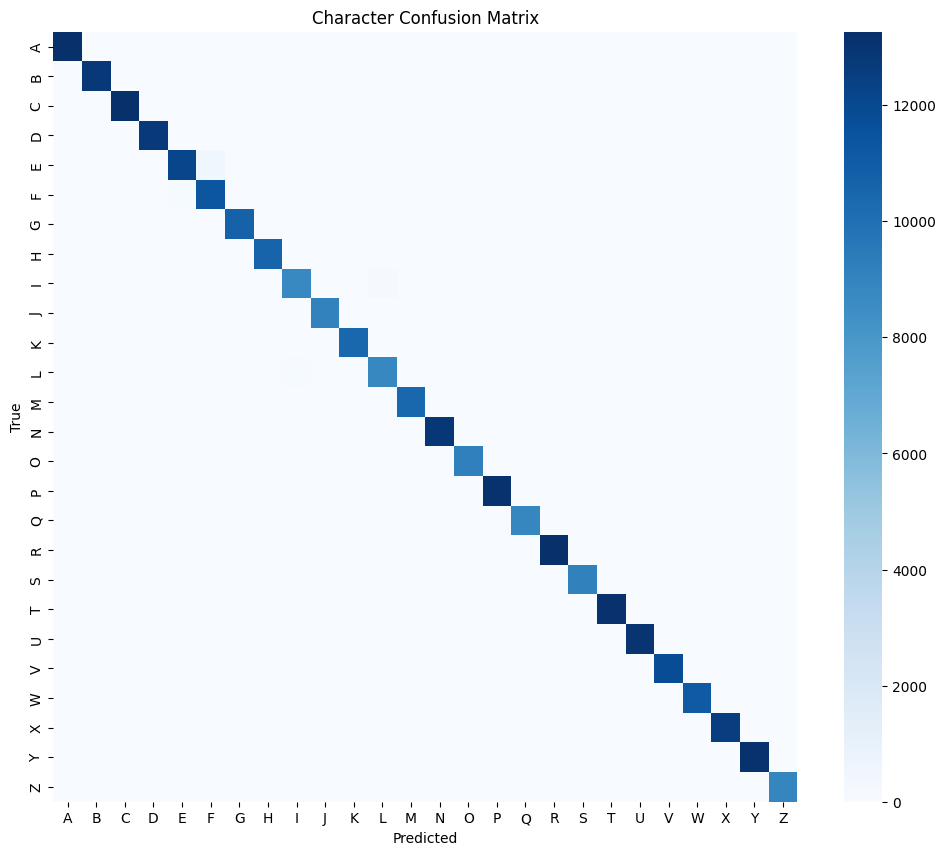

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00     13237
           B       1.00      1.00      1.00     12852
           C       0.99      1.00      1.00     13246
           D       1.00      1.00      1.00     12811
           E       0.99      0.96      0.98     12668
           F       0.96      0.99      0.97     11443
           G       1.00      1.00      1.00     10754
           H       1.00      1.00      1.00     10620
           I       0.99      0.98      0.98      8966
           J       1.00      1.00      1.00      9105
           K       1.00      1.00      1.00     10433
           L       0.98      0.99      0.98      8952
           M       1.00      1.00      1.00     10468
           N       1.00      1.00      1.00     12875
           O       1.00      1.00      1.00      9211
           P       1.00      1.00      1.00     13154
           Q       1.00      1.00      1.00      8890
    

In [28]:
# Align lengths for char-level evaluation
all_true_chars, all_pred_chars = [], []
for gt, pred in zip(all_gt, all_pred):
    min_len = min(len(gt), len(pred))
    all_true_chars.extend(list(gt[:min_len]))
    all_pred_chars.extend(list(pred[:min_len]))

# Confusion Matrix
cm = confusion_matrix(all_true_chars, all_pred_chars, labels=list(string.ascii_uppercase))

plt.figure(figsize=(12,10))
sns.heatmap(cm, xticklabels=list(string.ascii_uppercase),
            yticklabels=list(string.ascii_uppercase),
            cmap="Blues", fmt="d")
plt.title("Character Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Classification Report:")
print(classification_report(all_true_chars, all_pred_chars, labels=list(string.ascii_uppercase)))


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Overall metrics (macro = treats each class equally, weighted = weighted by support)
precision_macro = precision_score(all_true_chars, all_pred_chars, average="macro")
recall_macro    = recall_score(all_true_chars, all_pred_chars, average="macro")
f1_macro        = f1_score(all_true_chars, all_pred_chars, average="macro")

precision_weighted = precision_score(all_true_chars, all_pred_chars, average="weighted")
recall_weighted    = recall_score(all_true_chars, all_pred_chars, average="weighted")
f1_weighted        = f1_score(all_true_chars, all_pred_chars, average="weighted")

print("📊 Overall Metrics (Macro Avg)")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall:    {recall_macro:.4f}")
print(f"F1 Score:  {f1_macro:.4f}\n")

print("📊 Overall Metrics (Weighted Avg)")
print(f"Precision: {precision_weighted:.4f}")
print(f"Recall:    {recall_weighted:.4f}")
print(f"F1 Score:  {f1_weighted:.4f}")


📊 Overall Metrics (Macro Avg)
Precision: 0.9958
Recall:    0.9958
F1 Score:  0.9958

📊 Overall Metrics (Weighted Avg)
Precision: 0.9959
Recall:    0.9959
F1 Score:  0.9959


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


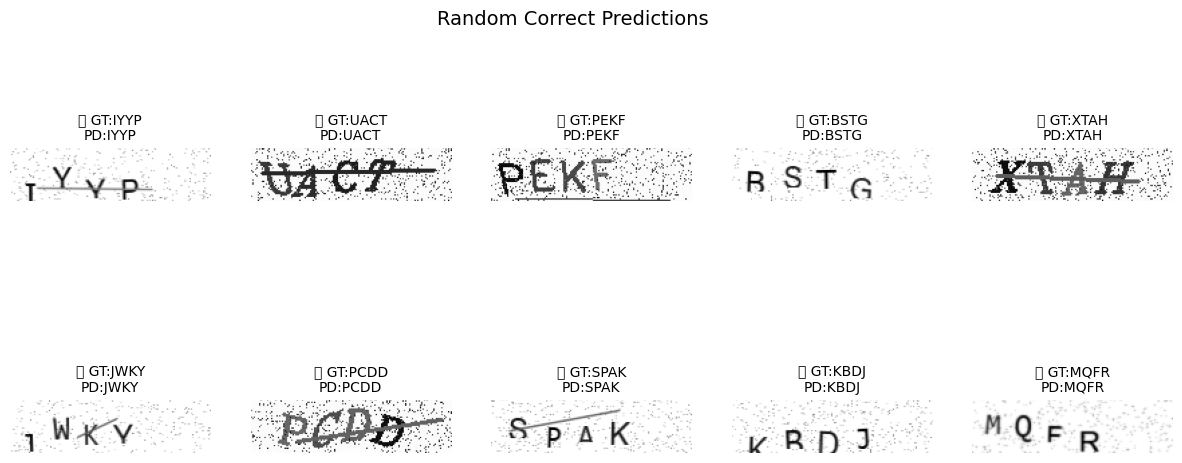

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


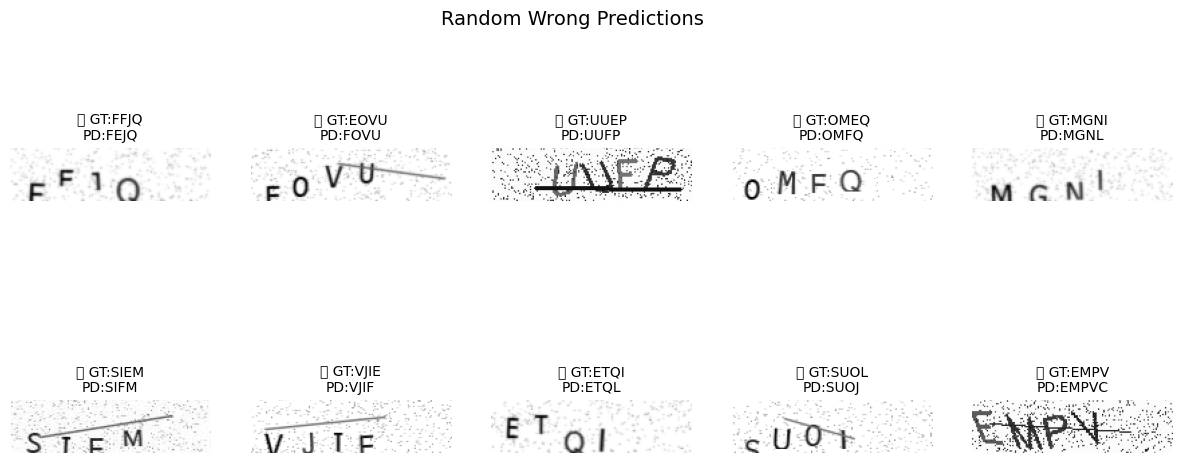

In [30]:
import random
import matplotlib.pyplot as plt

def show_random_predictions(model, loader, idx_to_char, num_correct=10, num_wrong=10):
    model.eval()
    correct_samples, wrong_samples = [], []

    with torch.no_grad():
        for imgs, labels, lengths in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(2).permute(1,0).cpu().numpy()  # [B,T]

            for i, gt in enumerate(labels):
                gt_str = "".join(idx_to_char[x.item()] for x in gt)
                pred_str = ctc_greedy_decode(preds[i], idx_to_char)

                sample = (imgs[i].cpu().squeeze().numpy(), gt_str, pred_str)

                if gt_str == pred_str and len(correct_samples) < num_correct:
                    correct_samples.append(sample)
                elif gt_str != pred_str and len(wrong_samples) < num_wrong:
                    wrong_samples.append(sample)

                # Stop early if we already have enough
                if len(correct_samples) >= num_correct and len(wrong_samples) >= num_wrong:
                    break
            if len(correct_samples) >= num_correct and len(wrong_samples) >= num_wrong:
                break

    # Plot correct predictions
    cols = 5
    rows = (num_correct + cols - 1) // cols
    plt.figure(figsize=(15, 3*rows))
    for i, (img, gt, pred) in enumerate(correct_samples):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(f"✅ GT:{gt}\nPD:{pred}", fontsize=10)
    plt.suptitle("Random Correct Predictions", fontsize=14)
    plt.show()

    # Plot wrong predictions
    cols = 5
    rows = (num_wrong + cols - 1) // cols
    plt.figure(figsize=(15, 3*rows))
    for i, (img, gt, pred) in enumerate(wrong_samples):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(f"❌ GT:{gt}\nPD:{pred}", fontsize=10)
    plt.suptitle("Random Wrong Predictions", fontsize=14)
    plt.show()

# 🔍 Run it on validation loader
show_random_predictions(model, val_loader, idx_to_char, num_correct=10, num_wrong=10)


In [37]:
from google.colab import files
uploaded = files.upload()  # Select 1 or more images from your PC


Saving LUKM_5513.png to LUKM_5513.png


In [38]:
from PIL import Image
import torch

def predict_single_image(model, img_path, transform, idx_to_char):
    model.eval()
    image = Image.open(img_path).convert("L")  # grayscale
    image = transform(image).unsqueeze(0).to(device)  # [1,1,H,W]

    with torch.no_grad():
        outputs = model(image)  # (T,B,C)
        preds = outputs.argmax(2).squeeze(1).cpu().numpy()
        pred_str = ctc_greedy_decode(preds, idx_to_char)

    print(f"🖼️ {img_path}")
    print(f"🔮 Predicted: {pred_str}")
    return pred_str


In [39]:
for fname in uploaded.keys():
    predict_single_image(model, fname, transform, idx_to_char)


🖼️ LUKM_5513.png
🔮 Predicted: LUKM


In [68]:
from google.colab import files
import zipfile, os

# Upload ZIP
uploaded = files.upload()   # choose your testset.zip

# Extract directly into /content/test_data
extract_dir = "/content/test_data"
os.makedirs(extract_dir, exist_ok=True)

zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extracted test set to:", extract_dir)
print("📸 Sample files:", os.listdir(extract_dir)[:10])


KeyboardInterrupt: 

In [69]:
class CAPTCHADataset(Dataset):
    def __init__(self, data_dir, transform=None, num_chars=4, alphabet=string.ascii_uppercase):
        self.data_dir = data_dir
        self.transform = transform
        self.num_chars = num_chars
        self.alphabet = alphabet

        self.char_to_idx = {c: i for i, c in enumerate(self.alphabet)}
        self.idx_to_char = {i: c for c, i in self.char_to_idx.items()}

        self.image_paths, self.labels = [], []

        for fname in sorted(os.listdir(data_dir)):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                label_str = fname.split("_")[0][:num_chars].upper()
                if len(label_str) == num_chars and all(c in self.alphabet for c in label_str):
                    self.image_paths.append(os.path.join(data_dir, fname))
                    label_indices = [self.char_to_idx[c] for c in label_str]
                    self.labels.append(torch.tensor(label_indices, dtype=torch.long))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [70]:
test_dataset = CAPTCHADataset(extract_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [71]:
from tqdm import tqdm
import pandas as pd

def evaluate_on_test(model, loader, dataset, out_csv=None):
    model.eval()
    all_gt, all_pred = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Testing"):
            imgs = imgs.to(device)
            outputs = model(imgs)  # (T,B,C)

            preds = outputs.argmax(2).cpu().numpy().T  # [B, T]
            for i, gt in enumerate(labels):
                true_str = "".join(dataset.idx_to_char[x.item()] for x in gt)
                pred_str = ctc_greedy_decode(preds[i], dataset.idx_to_char)
                all_gt.append(true_str)
                all_pred.append(pred_str)

    df = pd.DataFrame({"GroundTruth": all_gt, "Prediction": all_pred})
    if out_csv:
        df.to_csv(out_csv, index=False)
        print(f"✅ Saved test predictions to {out_csv}")

    # Quick sequence-level accuracy
    seq_acc = sum(g == p for g, p in zip(all_gt, all_pred)) / len(all_gt)
    print(f"🏆 Test Sequence Accuracy: {seq_acc*100:.2f}%")

    return df, all_gt, all_pred


In [72]:
ALPHABET = string.ascii_uppercase  # A–Z
# CTC requires: blank=0, chars start at 1
idx_to_char = {0: ""}  # blank
for i, c in enumerate(ALPHABET, start=1):
    idx_to_char[i] = c

def ctc_greedy_decode(preds, idx_to_char):
    prev = -1
    out = []
    for x in preds:
        if x != prev and x != 0:  # skip blanks
            if x in idx_to_char:  # safe guard
                out.append(idx_to_char[x])
        prev = x
    return "".join(out)


In [73]:
test_df, test_gt, test_pred = evaluate_on_test(
    model, test_loader, test_dataset, out_csv="/content/test_predictions.csv"
)


Testing: 100%|██████████| 157/157 [00:07<00:00, 20.33it/s]

✅ Saved test predictions to /content/test_predictions.csv
🏆 Test Sequence Accuracy: 0.00%


In [64]:
# Sequence accuracy
test_seq_acc = sum([g == p for g,p in zip(test_gt, test_pred)]) / len(test_gt)
print(f"🏆 Final Test Sequence Accuracy: {test_seq_acc*100:.2f}%")

# Character-level metrics
all_true_chars, all_pred_chars = [], []
for gt, pred in zip(test_gt, test_pred):
    min_len = min(len(gt), len(pred))
    all_true_chars.extend(list(gt[:min_len]))
    all_pred_chars.extend(list(pred[:min_len]))

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_true_chars, all_pred_chars, average="weighted")
recall    = recall_score(all_true_chars, all_pred_chars, average="weighted")
f1        = f1_score(all_true_chars, all_pred_chars, average="weighted")

print(f"📊 Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")


🏆 Final Test Sequence Accuracy: 0.00%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Precision: 0.0139 | Recall: 0.0153 | F1: 0.0140
